In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm #library to make a progress bar when doing long for loops
from scipy.optimize import curve_fit #for forcing curve fit
import time #for testing efficiency of code

import warnings
warnings.filterwarnings('ignore') #suppressed normal warnings (disable this if something stops working)

xy = 'y' #we looking at x or y?

In [7]:
def process(filename): #return a processed dataframe
    data = pd.read_excel(filename, 
                    names = ["globaltime","dt",'rb1x','rb1y','rb1z','rb2x','rb2y','rb2z',
                            'rb3x','rb3y','rb3z','rb4x','rb4y','rb4z','rb5x','rb5y','rb5z',
                            'rb6x','rb6y','rb6z','rb7x','rb7y','rb7z','rb8x','rb8y','rb8z',
                            'xd','yd','thetad'])

    while data.iloc[0]['rb1z']==0.0:
        data = data.drop(0)
        data.index-=1
        
    #calculate robot position at each point

    #calculate the center of the robot
    Adet = (data['rb1x']*(data['rb4y']-data['rb6y']) -
           data['rb1y']*(data['rb4x']-data['rb6x']) +
           data['rb4x']*data['rb6y']-data['rb6x']*data['rb4y'])

    Bdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb6y']-data['rb4y'])  +
           (data['rb4x']**2+data['rb4y']**2)*(data['rb1y']-data['rb6y'])  +
           (data['rb6x']**2+data['rb6y']**2)*(data['rb4y']-data['rb1y']) )

    Cdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb4x']-data['rb6x'])  +
           (data['rb4x']**2+data['rb4y']**2)*(data['rb6x']-data['rb1x'])  +
           (data['rb6x']**2+data['rb6y']**2)*(data['rb1x']-data['rb4x']) )

    x_r = -Bdet/(2.*Adet)/1000.+Bdet[0]/(2.*Adet[0])/1000. #robot global position x in meters (adjusted to origin)
    y_r = -Cdet/(2.*Adet)/1000.+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters

    x_mid = (data['rb1x']+data['rb8x'])/2./1000.+Bdet[0]/(2.*Adet[0])/1000. #calculate the midpoint of wheel 1 (adjusted to origin)
    y_mid = (data['rb1y']+data['rb8y'])/2./1000.+Cdet[0]/(2.*Adet[0])/1000.

    #rotate desired position to be in line with robot
    xd_rot = data['xd']
    yd_rot = data['yd']


    xr_rot =x_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+y_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
    yr_rot =y_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-x_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
    theta_r = np.arctan2(y_mid-y_r,x_mid-x_r) - np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]) #robot angle starting at 0
    
    pdata = pd.DataFrame()
    pdata.insert(0,"globaltime", data['globaltime'],True) #get global time
    pdata.insert(1, "x_r", xr_rot,True) #get robot positions (adjusted to origin)
    pdata.insert(2, "y_r", yr_rot,True)
    pdata.insert(3, "theta_r", theta_r,True)

    pdata.insert(4, "x_d", xd_rot,True) #get robot desired positions (adjusted for starting orientation)
    pdata.insert(5, "y_d", yd_rot,True)
    pdata.insert(6, "theta_d", data['thetad'],True)

    pdata.insert(7,'e_x', pdata['x_r']-pdata['x_d']) #calculate the errors at each point
    pdata.insert(8,'e_y', pdata['y_r']-pdata['y_d'])
    pdata.insert(9,'e_theta', pdata['theta_r']-pdata['theta_d'])
    
    return pdata


def get_points(df, points): #returns array of points
    
    smalldf = pd.DataFrame()
    
    for i in points:
        df_sort = df.iloc[(df['globaltime']-i).abs().argsort()[:2]].index.tolist() #get higher and lower value
        
        smalldf = smalldf.append(df.iloc[df_sort[0],:])
    
    smalldf.reset_index(inplace=True, drop=True)
    return smalldf
    

In [8]:
my_index = pd.MultiIndex(levels=[[]]*2,
                            labels=[[]]*2,
                            names=[u'trial',u'index'])
my_columns = [u'e_theta', u'e_x', u'e_y',u'globaltime',u'x_r',u'y_r',u'theta_r',u'x_d',u'y_d',u'theta_d']
multiframe=pd.DataFrame(index=my_index, columns=my_columns)

#pull_points=[2,10,18,26,34,42,50,58,66,74,82,90,98,106,114]
pull_points=[3,13,23,33,43,53,63,73,83,93,103,113,123,133,143]

for i in tqdm(range(5)):
    frame = process("./03-09-2020/SMC_"+xy+"_zigzag"+str(i)+".xlsx")
    frame = get_points(frame, pull_points)
    multiframe = multiframe.append(frame.assign(k='trial'+str(i)).set_index('k',append=True).swaplevel(0,1))

#my_index.append(b.assign(k='C').set_index('k',append=True).swaplevel(0,1))

TypeError: __new__() got an unexpected keyword argument 'labels'

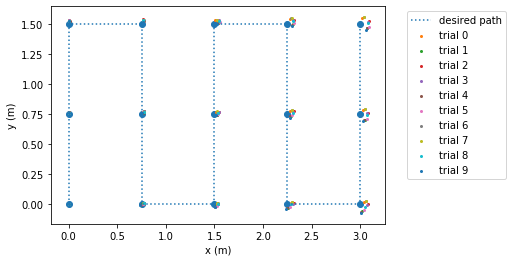

In [149]:
ax = plt.subplot(1,1,1)
ax.plot(multiframe.loc['trial0']['x_d'], multiframe.loc['trial0']['y_d'],':', label='desired path')
ax.scatter(multiframe.loc['trial0']['x_d'],multiframe.loc['trial0']['y_d'])
for i in range(10):
    ax.scatter(multiframe.loc['trial'+str(i)]['x_r'], multiframe.loc['trial'+str(i)]['y_r'],s=4, label='trial '+str(i))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.savefig('test.png',dpi=300)
plt.show()

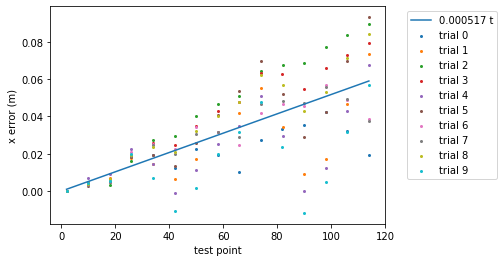

Drift = [0.01966029]m/m


In [150]:
def fit_func(x, a): #Come up with linear fits for drift (b=0)
    return a*x
m=0
for i in range(10):
    m = m+curve_fit(fit_func, multiframe.loc['trial'+str(i)]['globaltime'], multiframe.loc['trial'+str(i)]['e_'+xy])[0]/10.

ax = plt.subplot(1,1,1)
for i in range(10):
    ax.scatter(multiframe.loc['trial'+str(i)]['globaltime'],multiframe.loc['trial'+str(i)]['e_'+xy], s=4, label='trial '+str(i))
ax.plot(multiframe.loc['trial'+str(i)]['globaltime'],m*multiframe.loc['trial'+str(i)]['globaltime'],label=("%f t" % (m)))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('test point')
plt.ylabel(xy +' error (m)')
plt.show()   

print("Drift = " + str(m*114./3.) + "m/m")

In [151]:
RMSE = 0

for i in range(10):
    RMSE_x = multiframe.loc['trial'+str(i)]['e_x']**2
    RMSE_y = multiframe.loc['trial'+str(i)]['e_y']**2

RMSE_x = np.sqrt(RMSE_x/10)
RMSE_y = np.sqrt(RMSE_y/10)
RMSE_y*10**3

index
0      0.005725
1      3.858815
2      9.413700
3      6.117676
4      1.917051
5      3.320771
6      8.088773
7      3.712206
8      1.473953
9      4.748726
10     9.705333
11    14.851898
12    23.938462
13    19.463174
14    14.173280
Name: e_y, dtype: float64

In [152]:
RMSE_x*10**3

index
0      0.004629
1      1.433196
2      1.770478
3      6.228252
4      2.226558
5      3.374630
6      0.480472
7      6.373153
8     10.025047
9     15.105360
10     7.453962
11     3.688871
12     1.529763
13    10.011093
14    17.908021
Name: e_x, dtype: float64

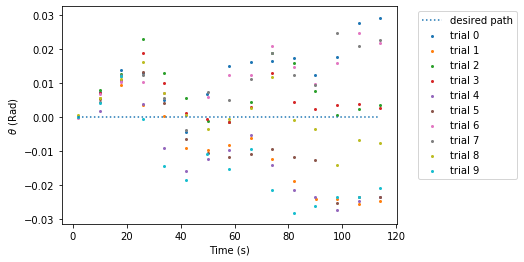

In [164]:
ax = plt.subplot(1,1,1)
ax.plot(multiframe.loc['trial0']['globaltime'], multiframe.loc['trial0']['theta_d'],':', label='desired path')
for i in range(10):
    ax.scatter(multiframe.loc['trial'+str(i)]['globaltime'], multiframe.loc['trial'+str(i)]['theta_r'],s=4, label='trial '+str(i))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Time (s)')
plt.ylabel(r'$\theta$ (Rad)')
plt.savefig('test.png',dpi=300)
plt.show()